$
\begin{align}
\nabla_\theta J(\theta) &= \mathbb{E}_{\pi_\theta}[\nabla_\theta \log \pi_\theta(s,a)G_t] \text{REINFORCE}\\
\nabla_\theta J(\theta) &= \mathbb{E}_{\pi_\theta}[\nabla_\theta \log \pi_\theta(s,a)V_w(s)] \text{V actor-critic}\\
\nabla_\theta J(\theta) &= \mathbb{E}_{\pi_\theta}[\nabla_\theta \log \pi_\theta(s,a)Q_w(s,a)] \text{Q actor-critic}\\
\nabla_\theta J(\theta) &= \mathbb{E}_{\pi_\theta}[\nabla_\theta \log \pi_\theta(s,a)A_w(s,a)] \text{Advantage actor-critic}\\
\end{align}
$

## Q actor critic

In [1]:
import numpy as np
import gym
import copy
import matplotlib.pyplot as plt
from tools import discount_cumsum, run_experiment_episode_train

In [2]:
import numpy as np

In [3]:
import tensorflow as tf

/home/raphael/rl_introduction/venv/lib/python3.6/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [4]:
import tensorflow.keras.backend as K

In [5]:
class DeepAgent:                                                                                                                                                                                                
    def __init__(self, env, is_deterministic = False, gamma = .99, epsilon = .01):                                                                                                                          
        self.env = env                                                                                                                                                                                      
        self.is_deterministic = is_deterministic                                                                                                                                                            
        self.gamma = gamma                                                                                                                                                                                  
        self.epsilon = epsilon                                                                                                                                                                              
        self.state_dim = env.observation_space.shape[0]
        self.action_dim = env.action_space.n
    def act(self, state):                                                                                                                                                                                   
        if self.is_deterministic:                                                                                                                                                                           
            action = np.argmax(self.policy[state])                                                                                                                                                          
        else:                                                                                                                                                                                               
            action = np.random.choice(np.arange(self.env.action_space.n),p=self.policy[state])                                                                                                              
            return action                                                                                                                                                                                       
        def train(current_state, action, reward, done):                                                                                                                                                         
            pass

In [6]:
import tensorflow.keras.backend as K

def policy_gradient_loss(returns):
    def modified_crossentropy(one_hot_action, action_probs):
        log_probs = K.sum(one_hot_action * K.log(action_probs) + (1 - one_hot_action) * K.log(1 - action_probs), axis=1)
        loss = -K.mean(returns * log_probs)
        return loss
    return modified_crossentropy

In [9]:
import gym
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, multiply, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop, Adam


class QActorCriticAgent(DeepAgent):
    def __init__(self, env, compiled_model = None, load_model_path = None, is_deterministic = False, gamma = .99, epsilon = .01, alpha = .01, memory_size = 4):
        super().__init__(env, is_deterministic, gamma, epsilon)
        
        if compiled_model is not None:
            self.model = compiled_model
        elif load_model_path is not None:
            self.model = load_model(load_model_path)
        else:
            self.model = self._build_model_actor()
        
        self.model.summary()
        
        self.model_critic = self._build_model_critic()
        
        self.model_critic.summary()
        
        self.episode = []
        self.memory_size = memory_size
        self.episodes = []
        self.turn = 0
        

    def _build_model_actor(self):
        input_state = Input(name='input_state', shape=(self.state_dim,), dtype='float32')
        input_discount_reward = Input(name='input_discount_reward', shape=(1,), dtype='float32')
        x = Dense(32, activation='relu')(input_state)
        x = Dense(32, activation='relu')(x)
        x = Dense(self.action_dim, activation='softmax')(x)
        model = Model(inputs=input_state, outputs=x)
        return model
    
    def _build_model_critic(self):
        input_state = Input(name='input_state', shape=(self.state_dim,), dtype='float32')
        x = Dense(32, activation='relu')(input_state)
        x = Dense(32, activation='relu')(x)
        x = Dense(1, activation='linear')(x)
        model = Model(inputs=input_state, outputs=x)
        model.compile(loss='mse', optimizer=Adam(learning_rate=1e-2))
        return model

    def act(self, state):
        state = state.reshape(1, -1)
        prob = self.model.predict(state, batch_size=1).flatten()
        action = np.random.choice(self.action_dim, 1, p=prob)[0]
        
        return action

    def train(self, current_state, action, reward, next_state, done):
        if done is False:
            self.episode.append(np.array([current_state, action, reward, reward + self.gamma * self.model_critic.predict(np.asarray(next_state).reshape(1,-1))]))
        else:
            self.episode.append(np.array([current_state, action, reward, reward]))
            episode = np.asarray(self.episode)
            self.episode = []
            discounted_return = discount_cumsum(episode[:,2], self.gamma).astype('float32')
            X = np.vstack(episode[:,0])
            Y_value = np.vstack(episode[:,3])
            Y = np.zeros((len(episode), self.action_dim))
            for i in range(len(episode)):
                Y[i, episode[i,1]] = 1
            if len(self.episodes) == self.memory_size:
                Xs = np.vstack([ep[0] for ep in self.episodes])
                Ys = np.vstack([ep[1] for ep in self.episodes])
                Y_values = np.vstack([ep[3] for ep in self.episodes])
                discounted_returns = np.hstack([ep[2] for ep in self.episodes])
                early_stopping = self.model_critic.train_on_batch(Xs,Y_values)
                baselines = self.model_critic.predict(Xs)
                loss = policy_gradient_loss(discounted_returns)#baselines)
                self.model.compile(loss=loss, optimizer=Adam(learning_rate=1e-2))
                self.model.train_on_batch(Xs,Ys)
                self.episodes = []
            else:
                self.episodes.append([X,Y,discounted_return, Y_value])

    def save_model(self, path):
        self.model.save(path)

$
\begin{align}

\end{align}
$

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_state (InputLayer)     [(None, 4)]               0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                160       
_________________________________________________________________
dense_7 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 66        
Total params: 1,282
Trainable params: 1,282
Non-trainable params: 0
_________________________________________________________________
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_state (InputLayer)     [(None, 4)]               0         
________________________________________

Text(0.5, 1.0, 'cumulative reward per episode - rand_agent')

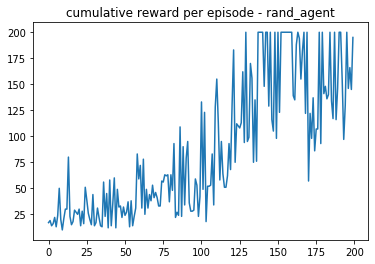

In [10]:
env = gym.make('CartPole-v0')
#env = gym.make('LunarLander-v2')
q_agent = QActorCriticAgent(env)
rewards = run_experiment_episode_train(env, q_agent, 200)
plt.plot(rewards)
plt.title('cumulative reward per episode - rand_agent')